# Text Representation with Feature Engineering

### Exploring Word Embeddings with New Deep Learning Models

We have discussed in the previous sub-unit that Feature Engineering is the secret sauce to creating superior and better performing machine learning models.

Traditional (count-based) feature engineering strategies for textual data involve models belonging to a family of models popularly known as the Bag of Words model. This includes term frequencies, TF-IDF (term frequency-inverse document frequency), N-grams and so on. While they are effective methods for extracting features from text, due to the inherent nature of the model being just a bag of unstructured words, we lose additional information like the semantics, structure, sequence and context around nearby words in each text document.

This forms as enough motivation for us to explore more sophisticated models which can capture this information and give us features which are vector representation of words, popularly known as embeddings.

Here we will explore the following feature engineering techniques:

- Word2Vec
- FastText

Predictive methods like Neural Network based language models try to predict words from its neighboring words looking at word sequences in the corpus and in the process it learns distributed representations giving us dense word embeddings. We will be focusing on these predictive methods in this article.

# Prepare a Sample Corpus

Let’s now take a sample corpus of documents on which we will run most of our analyses in this article. A corpus is typically a collection of text documents usually belonging to one or more subjects or domains.

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

# visualize embeddings
from sklearn.manifold import TSNE

pd.options.display.max_colwidth = 200

corpus = ['The sky is blue and beautiful.',
          'Love this blue and beautiful sky!',
          'The quick brown fox jumps over the lazy dog.',
          "A king's breakfast has sausages, ham, bacon, eggs, toast and beans",
          'I love green eggs, ham, sausages and bacon!',
          'The brown fox is quick and the blue dog is lazy!',
          'The sky is very blue and the sky is very beautiful today',
          'The dog is lazy but the brown fox is quick!'
]
labels = ['weather', 'weather', 'animals', 'food', 'food', 'animals', 'weather', 'animals']

corpus = np.array(corpus)
corpus_df = pd.DataFrame({'Document': corpus,
                          'Category': labels})
corpus_df = corpus_df[['Document', 'Category']]
corpus_df

,Document,Category
0,The sky is blue and beautiful.,weather
1,Love this blue and beautiful sky!,weather
2,The quick brown fox jumps over the lazy dog.,animals
3,"A king's breakfast has sausages, ham, bacon, eggs, toast and beans",food
4,"I love green eggs, ham, sausages and bacon!",food
5,The brown fox is quick and the blue dog is lazy!,animals
6,The sky is very blue and the sky is very beautiful today,weather
7,The dog is lazy but the brown fox is quick!,animals


Let's go ahead and pre-process our text data now

# Simple Text Pre-processing

Since the focus of this unit is on feature engineering, we will build a simple text pre-processor which focuses on removing special characters, extra whitespaces, digits, stopwords and lower casing the text corpus.

In [5]:
import nltk
import re

nltk.download('stopwords')
nltk.download('punkt')

stop_words = nltk.corpus.stopwords.words('english')

def normalize_document(doc):
    # lower case and remove special characters\whitespaces
    doc = re.sub(r'[^a-zA-Z\s]', '', doc, flags=re.I|re.A)
    doc = doc.lower()
    doc = doc.strip()
    # tokenize document
    tokens = nltk.word_tokenize(doc)
    # filter stopwords out of document
    filtered_tokens = [token for token in tokens if token not in stop_words]
    # re-create document from filtered tokens
    doc = ' '.join(filtered_tokens)
    return doc

normalize_corpus = np.vectorize(normalize_document)

norm_corpus = normalize_corpus(corpus)
norm_corpus

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/laurent/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/laurent/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


array(['sky blue beautiful', 'love blue beautiful sky',
       'quick brown fox jumps lazy dog',
       'kings breakfast sausages ham bacon eggs toast beans',
       'love green eggs ham sausages bacon',
       'brown fox quick blue dog lazy', 'sky blue sky beautiful today',
       'dog lazy brown fox quick'], dtype='<U51')

In [6]:
import nltk

tokenized_corpus = [nltk.word_tokenize(doc) for doc in norm_corpus]

In [7]:
tokenized_corpus

[['sky', 'blue', 'beautiful'],
 ['love', 'blue', 'beautiful', 'sky'],
 ['quick', 'brown', 'fox', 'jumps', 'lazy', 'dog'],
 ['kings', 'breakfast', 'sausages', 'ham', 'bacon', 'eggs', 'toast', 'beans'],
 ['love', 'green', 'eggs', 'ham', 'sausages', 'bacon'],
 ['brown', 'fox', 'quick', 'blue', 'dog', 'lazy'],
 ['sky', 'blue', 'sky', 'beautiful', 'today'],
 ['dog', 'lazy', 'brown', 'fox', 'quick']]

# The Word2Vec Model

This model was created by Google in 2013 and is a predictive deep learning based model to compute and generate high quality, distributed and continuous dense vector representations of words, which capture contextual and semantic similarity. Essentially these are unsupervised models which can take in massive textual corpora, create a vocabulary of possible words and generate dense word embeddings for each word in the vector space representing that vocabulary.

Usually you can specify the size of the word embedding vectors and the total number of vectors are essentially the size of the vocabulary. This makes the dimensionality of this dense vector space much lower than the high-dimensional sparse vector space built using traditional Bag of Words models.

There are two different model architectures which can be leveraged by Word2Vec to create these word embedding representations. These include,

- The Continuous Bag of Words (CBOW) Model
- The Skip-gram Model

## The Continuous Bag of Words (CBOW) Model

The CBOW model architecture tries to predict the current target word (the center word) based on the source context words (surrounding words).

Considering a simple sentence, ___“the quick brown fox jumps over the lazy dog”___, this can be pairs of __(context_window, target_word)__ where if we consider a context window of size 2, we have examples like __([quick, fox], brown)__, __([the, brown], quick)__, __([the, dog], lazy)__ and so on.

Thus the model tries to predict the __`target_word`__ based on the __`context_window`__ words.

![](https://i.imgur.com/ATyNx6u.png)


## The Skip-gram Model

The Skip-gram model architecture usually tries to achieve the reverse of what the CBOW model does. It tries to predict the source context words (surrounding words) given a target word (the center word).

Considering our simple sentence from earlier, ___“the quick brown fox jumps over the lazy dog”___. If we used the CBOW model, we get pairs of __(context_window, target_word)__ where if we consider a context window of size 2, we have examples like __([quick, fox], brown)__, __([the, brown], quick)__, __([the, dog], lazy)__ and so on.

Now considering that the skip-gram model’s aim is to predict the context from the target word, the model typically inverts the contexts and targets, and tries to predict each context word from its target word. Hence the task becomes to predict the context __[quick, fox]__ given target word __‘brown’__ or __[the, brown]__ given target word __‘quick’__ and so on.

Thus the model tries to predict the context_window words based on the target_word.

![](https://i.imgur.com/95f3eVF.png)

Further details can be found in [Text Analytics with Python](https://github.com/dipanjanS/text-analytics-with-python/tree/master/New-Second-Edition/Ch04%20-%20Feature%20Engineering%20for%20Text%20Representation)

# Robust Word2Vec Model with Gensim

The __`gensim`__ framework, created by Radim Řehůřek consists of a robust, efficient and scalable implementation of the Word2Vec model. We will leverage the same on our sample toy corpus. In our workflow, we will tokenize our normalized corpus and then focus on the following four parameters in the Word2Vec model to build it.

- __`size`:__ The word embedding dimensionality
- __`window`:__ The context window size
- __`min_count`:__ The minimum word count
- __`sample`:__ The downsample setting for frequent words
- __`sg`:__ Training model, 1 for skip-gram otherwise CBOW

We will build a simple Word2Vec model on the corpus and visualize the embeddings.

In [8]:
import gensim
import pkg_resources
gensim_version = pkg_resources.get_distribution("gensim").version
print(gensim_version)

#gensim.__version__
#4.0.0

3.8.0


/var/folders/ld/c81z579x7n940m4_d4tq448m0000gp/T/ipykernel_95249/1285394414.py:2: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  import pkg_resources


In [9]:
tokenized_corpus

[['sky', 'blue', 'beautiful'],
 ['love', 'blue', 'beautiful', 'sky'],
 ['quick', 'brown', 'fox', 'jumps', 'lazy', 'dog'],
 ['kings', 'breakfast', 'sausages', 'ham', 'bacon', 'eggs', 'toast', 'beans'],
 ['love', 'green', 'eggs', 'ham', 'sausages', 'bacon'],
 ['brown', 'fox', 'quick', 'blue', 'dog', 'lazy'],
 ['sky', 'blue', 'sky', 'beautiful', 'today'],
 ['dog', 'lazy', 'brown', 'fox', 'quick']]

In [10]:
from gensim.models import word2vec


# Set values for various parameters
feature_size = 15    # Word vector dimensionality  every word -> [......] -> 15
window_context = 5  # Context window size
min_word_count = 1   # Minimum word count
sg = 1               # skip-gram model if sg = 1 and CBOW if sg = 0

w2v_model = word2vec.Word2Vec(tokenized_corpus,
                              vector_size=feature_size,
                              window=window_context,
                              min_count = min_word_count,
                              sg=sg, epochs=5000)
w2v_model

In [11]:
w2v_model.wv['bacon']

array([ 0.49109867,  0.03990211,  0.770674  ,  0.13783   ,  0.92748624,
        0.9528634 ,  0.30481634,  0.6881001 , -0.18886131,  0.35705924,
        0.00121468, -0.01715148, -0.6461186 , -1.2029033 ,  0.7898431 ],
      dtype=float32)

In [12]:
w2v_model.wv['bacon'].shape

(15,)

/Users/laurent/anaconda3/envs/tf_metal_gpu/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


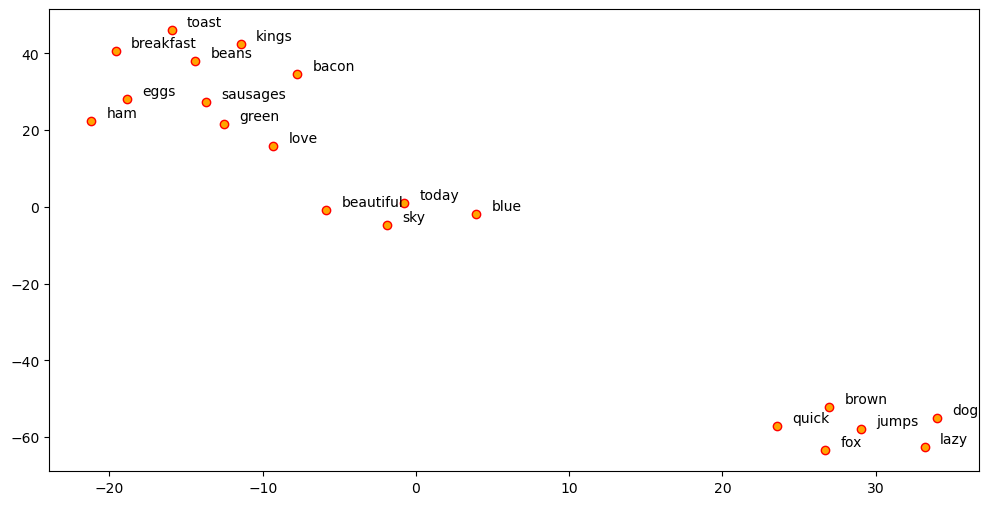

In [13]:
words = w2v_model.wv.index_to_key
wvs = w2v_model.wv[words]

tsne = TSNE(n_components=2, random_state=42, n_iter=5000, perplexity=5)
np.set_printoptions(suppress=True)
T = tsne.fit_transform(wvs)
labels = words

plt.figure(figsize=(12, 6))
plt.scatter(T[:, 0], T[:, 1], c='orange', edgecolors='r')
for label, x, y in zip(labels, T[:, 0], T[:, 1]):
    plt.annotate(label, xy=(x+1, y+1), xytext=(0, 0), textcoords='offset points')

In [14]:
w2v_model.wv['sky'], w2v_model.wv['sky'].shape

(array([-0.66495234,  0.1875716 ,  1.1314961 ,  0.3352689 , -0.5713678 ,
        -0.40595096,  0.91428745,  1.1767576 , -0.13541356,  0.68867517,
         0.6683381 ,  0.7583637 , -0.5936025 , -0.70269173,  0.14683926],
       dtype=float32),
 (15,))

In [15]:
vec_df = pd.DataFrame(wvs, index=words)
vec_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
sky,-0.664952,0.187572,1.131496,0.335269,-0.571368,-0.405951,0.914287,1.176758,-0.135414,0.688675,0.668338,0.758364,-0.593602,-0.702692,0.146839
blue,-0.656188,0.316094,0.590275,-0.067444,-0.710600,0.002632,0.578284,0.642111,0.081059,0.678017,0.270965,0.730968,-0.182894,-0.650552,-0.116814
lazy,-1.017472,0.479498,0.703476,-0.979142,-0.580434,0.153959,-0.057016,-0.469528,0.526443,0.058089,-0.355383,1.463150,-0.433897,-0.955880,0.411157
beautiful,-0.561235,-0.097759,1.115509,0.390801,-0.111527,-0.580653,0.806952,0.829562,-0.031684,0.985687,0.373037,0.802444,-0.583879,-0.615481,0.294894
quick,-0.969173,0.522417,0.309162,-0.723074,-0.645469,0.199756,-0.271358,-0.204773,0.402354,0.188028,0.121305,1.687323,-0.276257,-1.019778,0.369399
brown,-0.801386,0.835670,0.321340,-0.746366,-0.892001,0.345160,-0.192803,-0.070770,0.770727,0.020279,0.036139,1.590058,-0.296581,-0.981129,0.548340
fox,-0.862150,0.484128,0.626514,-0.695009,-0.400316,0.319726,-0.365641,-0.454502,0.520025,0.561568,-0.213334,1.593831,0.008031,-0.711407,0.616616
dog,-1.019500,0.532841,0.810008,-0.595242,-0.584081,0.224667,-0.565349,-0.404199,0.643921,0.358399,0.261429,1.521628,0.091438,-0.917416,0.383747
sausages,0.197532,0.243162,0.965944,-0.358200,1.066212,0.611936,-0.157123,0.636238,-0.122185,0.142828,0.499365,-0.407096,-0.507338,-1.119996,0.732976
ham,0.246316,0.599183,0.964551,0.437242,1.244191,0.898445,-0.160411,0.301443,-0.163626,0.020812,0.506816,0.025509,-0.558090,-0.992699,0.695752


### Looking at term semantic similarity

In [16]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

similarity_matrix = cosine_similarity(vec_df.values)
similarity_df = pd.DataFrame(similarity_matrix, index=words, columns=words)
similarity_df

,sky,blue,lazy,beautiful,quick,brown,fox,dog,sausages,ham,bacon,eggs,love,breakfast,kings,green,jumps,toast,beans,today
sky,1.000000,0.902824,0.387526,0.949665,0.441492,0.416770,0.347113,0.408618,0.315510,0.283506,0.372330,0.251563,0.720693,0.170630,0.260474,0.355589,0.282674,0.197510,0.262587,0.975937
blue,0.902824,1.000000,0.603117,0.826078,0.663975,0.647188,0.579471,0.624345,0.168239,0.129002,0.241689,0.123637,0.541497,0.111279,0.114397,0.210718,0.548964,0.100873,0.140037,0.901338
lazy,0.387526,0.603117,1.000000,0.385015,0.950684,0.934693,0.938283,0.916142,0.141627,0.124668,0.131044,0.144119,0.126962,0.213128,0.182282,0.186190,0.950289,0.190459,0.175570,0.372324
beautiful,0.949665,0.826078,0.385015,1.000000,0.409298,0.351686,0.385110,0.399887,0.334696,0.313238,0.421402,0.305033,0.711157,0.190505,0.276636,0.355189,0.256296,0.180557,0.258138,0.962035
quick,0.441492,0.663975,0.950684,0.409298,1.000000,0.969621,0.941802,0.951269,0.121341,0.137844,0.113500,0.121679,0.140159,0.199725,0.154330,0.136402,0.968596,0.212651,0.139438,0.441685
brown,0.416770,0.647188,0.934693,0.351686,0.969621,1.000000,0.913734,0.922770,0.123811,0.141477,0.124140,0.148225,0.088313,0.217147,0.168553,0.131872,0.961312,0.226635,0.173558,0.385660
fox,0.347113,0.579471,0.938283,0.385110,0.941802,0.913734,1.000000,0.960915,0.139847,0.171447,0.146613,0.167624,0.085805,0.220245,0.153868,0.160833,0.956197,0.187096,0.146450,0.358622
dog,0.408618,0.624345,0.916142,0.399887,0.951269,0.922770,0.960915,1.000000,0.160799,0.187296,0.094941,0.160457,0.175422,0.186078,0.126053,0.193421,0.955243,0.189444,0.123807,0.397540
sausages,0.315510,0.168239,0.141627,0.334696,0.121341,0.123811,0.139847,0.160799,1.000000,0.897000,0.891550,0.936288,0.754946,0.932017,0.929900,0.956997,0.156999,0.924681,0.949934,0.287115
ham,0.283506,0.129002,0.124668,0.313238,0.137844,0.141477,0.171447,0.187296,0.897000,1.000000,0.882641,0.909718,0.709952,0.852402,0.876714,0.915334,0.192176,0.847068,0.906834,0.250877


In [17]:
feature_names = np.array(words)
similarity_df.apply(lambda row: feature_names[np.argsort(-row.values)[1:4]],
                    axis=1)

sky              [today, beautiful, blue]
blue              [sky, today, beautiful]
lazy                  [quick, jumps, fox]
beautiful              [today, sky, blue]
quick                 [brown, jumps, dog]
brown                [quick, jumps, lazy]
fox                   [dog, jumps, quick]
dog                   [fox, jumps, quick]
sausages             [green, beans, eggs]
ham                  [green, eggs, beans]
bacon            [beans, kings, sausages]
eggs             [sausages, kings, beans]
love               [green, sausages, sky]
breakfast        [beans, toast, sausages]
kings           [beans, toast, breakfast]
green              [sausages, beans, ham]
jumps                 [quick, brown, fox]
toast           [kings, breakfast, beans]
beans        [kings, breakfast, sausages]
today              [sky, beautiful, blue]
dtype: object

# The FastText Model

The FastText model was first introduced by Facebook in 2016 as an extension and supposedly improvement of the vanilla Word2Vec model. Based on the original paper titled _[‘Enriching Word Vectors with Subword Information’](https://arxiv.org/pdf/1607.04606.pdf)_ by Mikolov et al. which is an excellent read to gain an in-depth understanding of how this model works. Overall, FastText is a framework for learning word representations and also performing robust, fast and accurate text classification. The framework is open-sourced by Facebook on [GitHub](https://github.com/facebookresearch/fastText) and claims to have the following.

- Recent state-of-the-art English word vectors.
- Word vectors for 157 languages trained on Wikipedia and Crawl.
- Models for language identification and various supervised tasks.

Though I haven't implemented this model from scratch, based on the research paper, following is what I learnt about how the model works. In general, predictive models like the Word2Vec model typically considers each word as a distinct entity (e.g. where) and generates a dense embedding for the word. However this poses to be a serious limitation with languages having massive vocabularies and many rare words which may not occur a lot in different corpora.

The Word2Vec model typically ignores the morphological structure of each word and considers a word as a single entity. The FastText model ___considers each word as a Bag of Character n-grams___. This is also called as a ___subword model___ in the paper.

We add special boundary symbols __<__ and __>__ at the beginning and end of words. This enables us to distinguish prefixes and suffixes from other character sequences. We also include the word __w__ itself in the set of its n-grams, to learn a representation for each word (in addition to its character n-grams).

Taking the word where and __n=3 (tri-grams)__ as an example, it will be represented by the __character n-grams__: __<wh, whe, her, ere, re>__ and the special sequence __< where >__ representing the whole word. Note that the sequence , corresponding to the word __< her >__ is different from the tri-gram __her__ from the word __where__.

In practice, the paper recommends in extracting all the n-grams for __n ≥ 3__ and __n ≤ 6__. This is a very simple approach, and different sets of n-grams could be considered, for example taking all prefixes and suffixes. We typically associate a vector representation (embedding) to each n-gram for a word.

Thus, we can represent a word by the sum of the vector representations of its n-grams or the average of the embedding of these n-grams. Thus, due to this effect of leveraging n-grams from individual words based on their characters, there is a higher chance for rare words to get a good representation since their character based n-grams should occur across other words of the corpus.

# Robust FastText Model with Gensim

The __`gensim`__ package has nice wrappers providing us interfaces to leverage the FastText model available under the `gensim.models.fasttext` module. Let’s apply this once again on our toy corpus.

In [18]:
from gensim.models.fasttext import FastText

# Set values for various parameters
feature_size = 15    # Word vector dimensionality
window_context = 5  # Context window size
min_word_count = 1   # Minimum word count
sg = 1               # skip-gram model

ft_model = FastText(tokenized_corpus,
                    vector_size=feature_size,
                     window=window_context,
                    min_count = min_word_count,
                     sg=sg, epochs=5000)
ft_model

/Users/laurent/anaconda3/envs/tf_metal_gpu/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


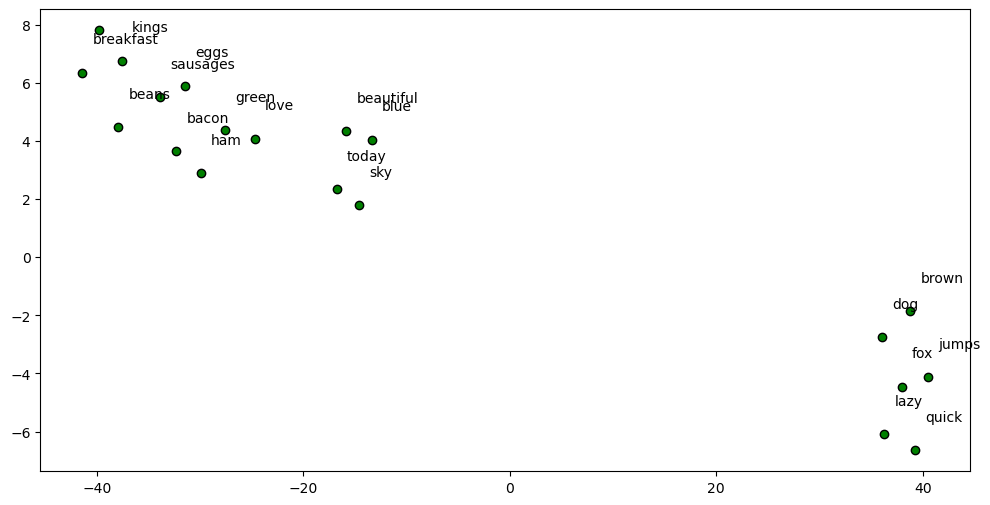

In [19]:
# visualize embeddings
from sklearn.manifold import TSNE

words = ft_model.wv.index_to_key
wvs = ft_model.wv[words]

tsne = TSNE(n_components=2, random_state=42, n_iter=5000, perplexity=5)
np.set_printoptions(suppress=True)
T = tsne.fit_transform(wvs)
labels = words

plt.figure(figsize=(12, 6))
plt.scatter(T[:, 0], T[:, 1], c='green', edgecolors='k')
for label, x, y in zip(labels, T[:, 0], T[:, 1]):
    plt.annotate(label, xy=(x+1, y+1), xytext=(0, 0), textcoords='offset points')

## Embedding Operations

In [20]:
ft_model.wv['sky'], ft_model.wv['sky'].shape

(array([ 0.89208215,  0.30377802,  1.3402691 ,  0.19144842, -0.16931698,
         0.10213633,  0.22142614,  0.6593981 ,  0.74572927,  0.21548243,
         0.05870125, -0.41944942,  0.0704999 , -0.7859734 ,  0.3600889 ],
       dtype=float32),
 (15,))

In [21]:
print(ft_model.wv.similarity(w1='ham', w2='sky'))
print(ft_model.wv.similarity(w1='ham', w2='sausages'))

0.37628302
0.9760692


In [22]:
st1 = "dog fox ham"
print('Odd one out for [',st1, ']:',
      ft_model.wv.doesnt_match(st1.split()))

st2 = "bacon ham sky sausages"
print('Odd one out for [',st2, ']:',
      ft_model.wv.doesnt_match(st2.split()))

Odd one out for [ dog fox ham ]: ham
Odd one out for [ bacon ham sky sausages ]: sky


### Getting document level embeddings

Now suppose we wanted to cluster the eight documents from our toy corpus, we would need to get the document level embeddings from each of the words present in each document. One strategy would be to average out the word embeddings for each word in a document. This is an extremely useful strategy and you can adopt the same for your own problems. Let’s apply this now on our corpus to get features for each document.

```
['sky', 'blue', 'beautiful'] => sum(sky[...], blue[...], beautiful[...]) / 3 => [...]

['love', 'blue', 'beautiful', 'sky'] => sum(love[...], sky[...], blue[...], beautiful[...]) / 4 => [...]
```

In [23]:
def average_word_vectors(words, model, vocabulary, num_features):

    feature_vector = np.zeros((num_features,),dtype="float64") # avg embedding for the tokenized doc ['sky', 'blue', 'beautiful']
    nwords = 0.

    for word in words: # for every word in a document, find the word embedding and add it to feature_vector
        if word in vocabulary:
            nwords = nwords + 1.    # 1 + 1 + 1 = 3
            feature_vector = np.add(feature_vector, model.wv[word])
            # model.wv['sky'] + model.wv['blue'] + model.wv['beautiful'] = sum(3x15) = 1x15

    if nwords:
        feature_vector = np.divide(feature_vector, nwords)  # 1x15 / 3

    return feature_vector


def averaged_word_vectorizer(corpus, model, num_features):
    vocabulary = set(model.wv.index_to_key) # set of unique words across the corpus
    features = [average_word_vectors(tokenized_sentence, model, vocabulary, num_features)
                    for tokenized_sentence in corpus]
    return np.array(features)

In [24]:
# get document level embeddings
ft_doc_features = averaged_word_vectorizer(corpus=tokenized_corpus,
                                           model=ft_model,
                                           num_features=feature_size)
pd.DataFrame(ft_doc_features)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,0.702208,0.269721,1.208595,0.135956,-0.136051,0.188537,0.193788,0.667130,0.720404,0.129991,0.066564,-0.276495,0.081023,-0.734131,0.287957
1,0.614661,0.167288,1.070228,0.177391,-0.154524,0.119987,0.210237,0.616474,0.508951,0.171895,-0.037331,-0.331128,0.029928,-0.636714,0.278297
2,-0.621004,-0.375168,1.307166,0.011855,0.424296,1.230960,0.058323,0.372937,0.371490,-0.550137,0.465869,0.370083,-0.139560,-0.875295,-0.036917
3,-0.338122,-0.758968,0.671091,0.650263,-0.091861,-0.021209,0.370908,0.966709,-0.813110,0.677825,-0.692914,-0.828494,-0.604495,-0.535674,0.456747
4,-0.064380,-0.562713,0.666517,0.483645,-0.138747,-0.070524,0.313919,0.745740,-0.585607,0.520090,-0.620565,-0.650668,-0.460422,-0.439147,0.383754
5,-0.438472,-0.267396,1.285963,0.011668,0.346730,1.077411,0.075466,0.410457,0.438525,-0.471851,0.420271,0.290799,-0.096189,-0.839637,-0.000701
6,0.752095,0.284586,1.215895,0.173595,-0.156734,0.160762,0.206683,0.678425,0.739144,0.163503,0.067645,-0.325152,0.098114,-0.742686,0.301414
7,-0.606687,-0.362380,1.325671,0.020353,0.423995,1.233242,0.056938,0.369613,0.389212,-0.547239,0.473006,0.371934,-0.133367,-0.881733,-0.029158


### Trying out document clustering

Now that we have our features for each document, let’s cluster these documents using the Affinity Propagation algorithm, which is a clustering algorithm based on the concept of “message passing” between data points and does not need the number of clusters as an explicit input which is often required by partition-based clustering algorithms.

In [25]:
from sklearn.cluster import AffinityPropagation

ap = AffinityPropagation()
ap.fit(ft_doc_features)

cluster_labels = ap.labels_
cluster_labels = pd.DataFrame(cluster_labels,
                              columns=['ClusterLabel'])

pd.concat([corpus_df, cluster_labels], axis=1)

,Document,Category,ClusterLabel
0,The sky is blue and beautiful.,weather,0
1,Love this blue and beautiful sky!,weather,0
2,The quick brown fox jumps over the lazy dog.,animals,2
3,"A king's breakfast has sausages, ham, bacon, eggs, toast and beans",food,1
4,"I love green eggs, ham, sausages and bacon!",food,1
5,The brown fox is quick and the blue dog is lazy!,animals,2
6,The sky is very blue and the sky is very beautiful today,weather,0
7,The dog is lazy but the brown fox is quick!,animals,2


We can see that our algorithm has clustered each document into the right group based on our Word2Vec features. Pretty neat! We can also visualize how each document in positioned in each cluster by using [_Principal Component Analysis (PCA)_](https://en.wikipedia.org/wiki/Principal_component_analysis) to reduce the feature dimensions to 2-D and then visualizing the same (by color coding each cluster).

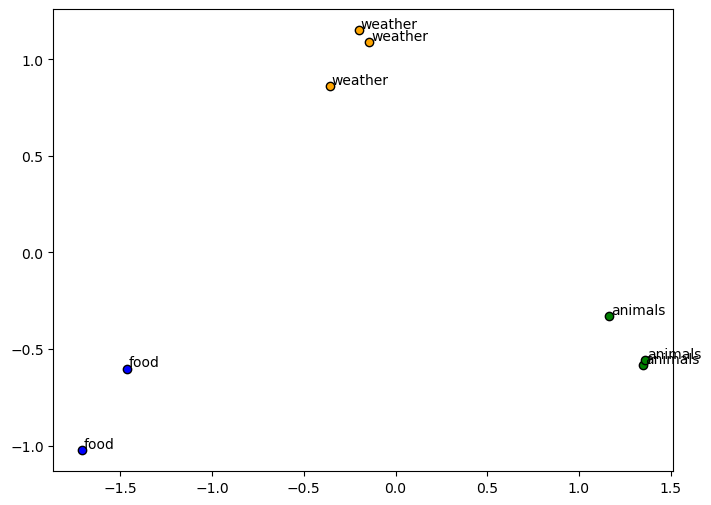

In [26]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2, random_state=42)
pcs = pca.fit_transform(ft_doc_features)
labels = ap.labels_
categories = list(corpus_df['Category'])
plt.figure(figsize=(8, 6))

for i in range(len(labels)):
    label = labels[i]
    color = 'orange' if label == 0 else 'blue' if label == 1 else 'green'
    annotation_label = categories[i]
    x, y = pcs[i]
    plt.scatter(x, y, c=color, edgecolors='k')
    plt.annotate(annotation_label, xy=(x+1e-2, y+1e-2), xytext=(0, 0),
                 textcoords='offset points')

Everything looks to be in order as documents in each cluster are closer to each other and far apart from other clusters.